In [16]:
import sys
sys.path.append("../")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd

from experiments import RandomWalkDiffusionExperiment
from models import RandomWalkDiffusion

In [20]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = True
FIT_MODEL = True

N_SAMPLES = 2000

LOCAL_PARAM_LABELS = ['Drift rate', 'Drift rate', 'Threshold', 'Non-decision time', 'Bias']
LOCAL_PARAM_NAMES  = [r'v_1', r'v_2', r'a', r'\tau', r'\beta']

FONT_SIZE_1 = 18
FONT_SIZE_2 = 16
FONT_SIZE_3 = 12

# import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Palatino"
# matplotlib.rcParams['font.family'] = "sans-serif"

# Neural Experiment

In [18]:
model = RandomWalkDiffusion()
neural_experiment = RandomWalkDiffusionExperiment(model)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 112, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 112)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 112, 5)
INFO:root:No shared_prior_draws provided.
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes care of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with 

## Training

In [21]:
if TRAIN_NETWORKS:
    history = neural_experiment.run(
        epochs=50, 
        iterations_per_epoch=1000, 
        batch_size=32
    )
else:
    history = neural_experiment.trainer.loss_history.get_plottable()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/1000 [00:00<?, ?it/s]

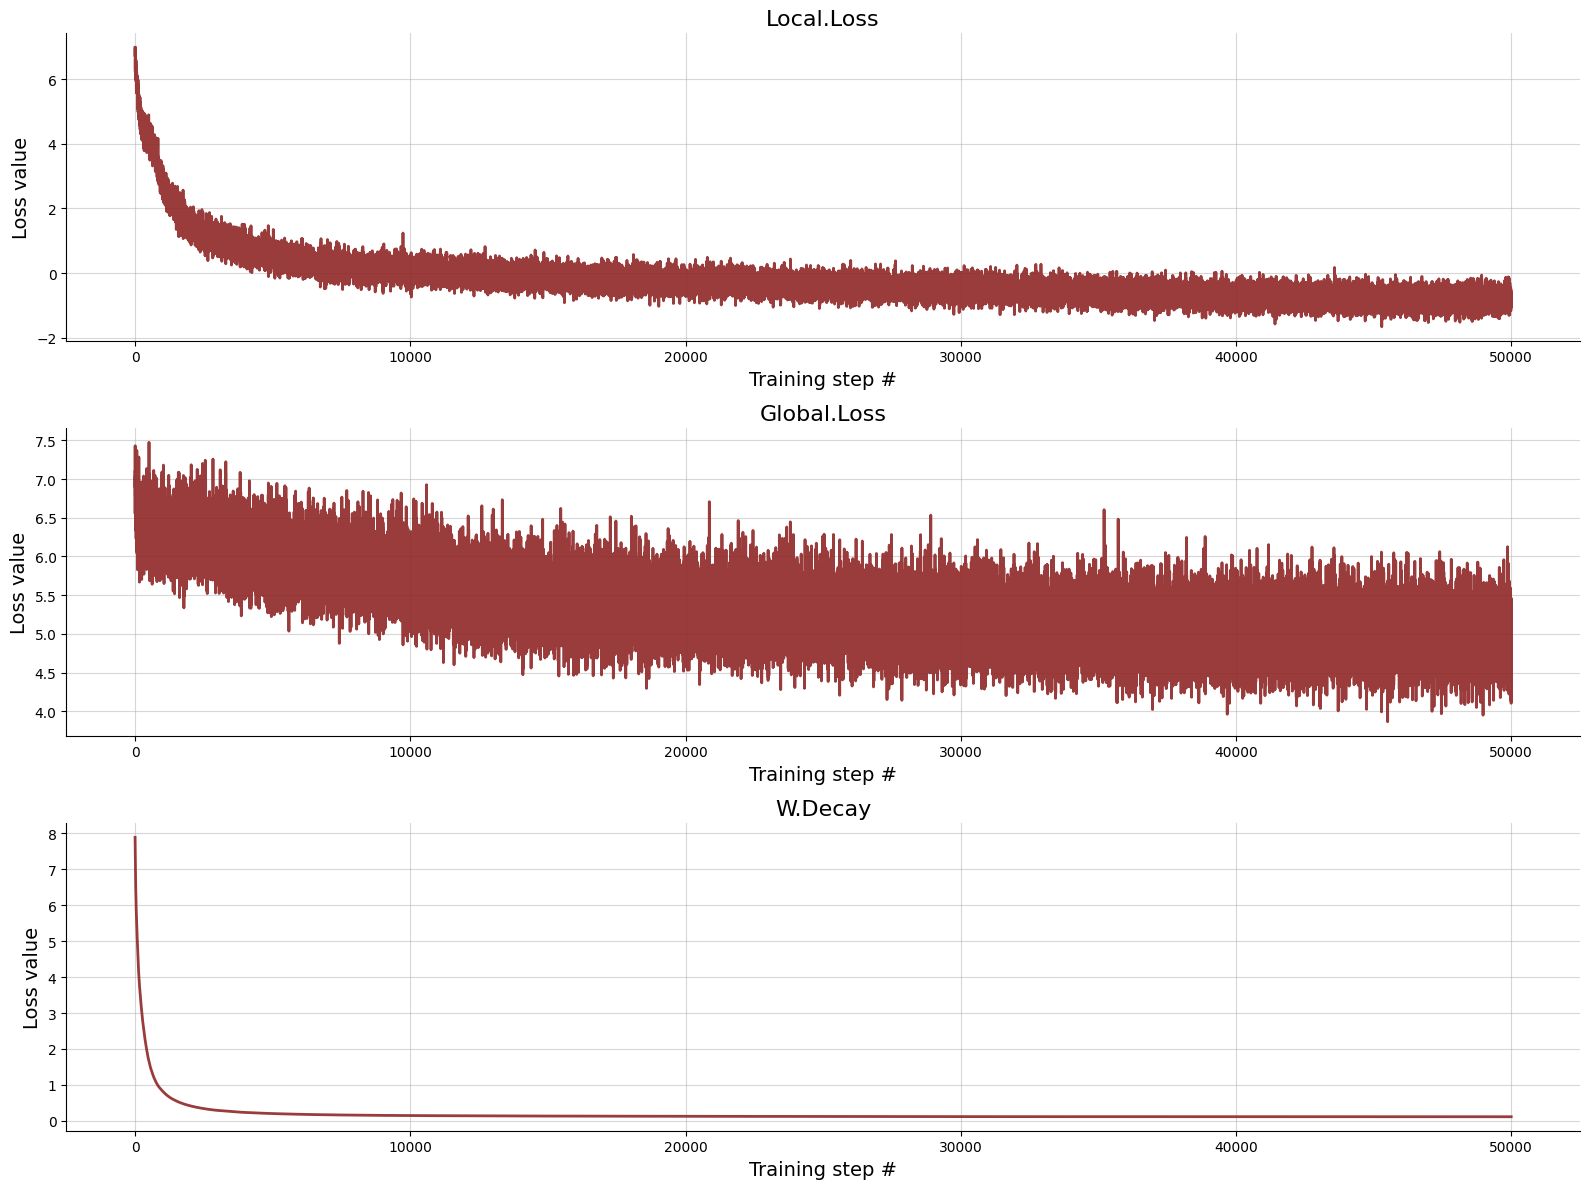

In [22]:
f = beef.diagnostics.plot_losses(history)

In [29]:
data = pd.read_csv("../data/yes_no_data_picture.csv")
data["rt"][data["new_resp"] == 1] = -data["rt"][data["new_resp"] == 1]
N_OBS = 112
N_SUB = len(np.unique(data['id']))

/tmp/ipykernel_2757/45531790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["rt"][data["new_resp"] == 1] = -data["rt"][data["new_resp"] == 1]


In [ ]:
if FIT_MODEL:
    post_samples = np.full((N_SUB, N_OBS, N_SAMPLES, 5), np.nan)
    with tf.device('/cpu:0'):
        for i in range(N_SUB):
            person_data = data[data['id'] == i+1]
            rt = person_data['rt'].to_numpy()
            context = person_data['new_item'].to_numpy()
            mask = np.isfinite(rt)
            person_data = np.c_[rt, context]
            person_data = person_data[mask, :]
            tmp_data = {'summary_conditions': person_data[None, :, :]}
            samples = neural_experiment.amortizer.sample(tmp_data, N_SAMPLES)['local_samples']
            post_samples[i, mask, :, :] = samples
        np.save("../data/posterior_samples_pictures.npy", post_samples)
else:
    post_samples = np.load("../data/posterior_samples_pictures.npy")

In [ ]:
post_samples_not_z = post_samples * model.local_prior_stds + model.local_prior_means
post_means = np.nanmean(post_samples_not_z, axis=2)
post_std = np.nanstd(post_samples_not_z, axis=2)
post_means_mean = np.nanmean(post_means, axis=0)
post_means_std = np.nanstd(post_means, axis=0)
np.save("../data/posterior_means.npy", post_means)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        range(N_OBS), post_means_mean[:, i],
        color='maroon'
    )
    ax.fill_between(
        range(N_OBS),
        post_means_mean[:, i] - post_means_std[:, i],
        post_means_mean[:, i] + post_means_std[:, i],
        color='maroon', alpha=0.6
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)

    
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 2:
        ax.set_ylim([0.0, 3.0])
    if i ==1 :
        ax.set_ylim([-3.0, 0.0])
    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

sns.despine()
f.tight_layout()
plt.savefig('../plots/parameter_dynamic_1.png', dpi=300)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axarr.flat):
    if i == 2:
        break
    ax.grid(alpha=0.5)
    ax.plot(
        range(N_OBS), post_means_mean[:, i+3],
        color='maroon'
    )
    ax.fill_between(
        range(N_OBS),
        post_means_mean[:, i+3] - post_means_std[:, i+3],
        post_means_mean[:, i+3] + post_means_std[:, i+3],
        color='maroon', alpha=0.6
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i+3]} (${LOCAL_PARAM_NAMES[i+3]}$)', fontsize=FONT_SIZE_1)

    
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i+3 == 0 or i+3 == 2:
        ax.set_ylim([0.0, 3.0])
    if i+3 ==1 :
        ax.set_ylim([-3.0, 0.0])
    if i+3 == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

sns.despine()
# f.tight_layout()

plt.savefig('../plots/parameter_dynamic_2.png', dpi=300)

## Posterior resimulation

In [ ]:
N_RESIM = 100 # randomly sample from posterior


pred_data = np.zeros((N_RESIM, N_SUB, N_OBS, 1))
# for

post_samples.shape

post_samples[0, :, 345, :]

sample_random_walk_diffusion_process()